## Doc2Vec Intro

We've seen different ways to create the numerical features for text such as vector representation using Bag of Words, Tf-IDF etc.

Our focus here is learning doc2vec derived from Google's 2013 word2vec model. 

Here we create the *word embeddings*, by taking as input a large corpus of text and producing a vector space typically of several hundred dimesions (via projection onto lower-Dim spaces).

The idea behind Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model.

Encapsulated in the famous adage: *A word is known by the company it keeps.*

First things first, reading in reqd libraries.

In [16]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import time, requests, re
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn_extra.cluster import KMedoids

Below, we start simple. One toy example. Then we write funcs to scale over real-world corpora. 

### Dummy Example

Things to note: a *tagged_doc* is the input format doc2vec demands. What is it? We'll see.

In [2]:
# prep data 4 trg
data = ["I love machine learning. Its awesome.",
        "I love coding in python",
        "I love building chatbots",
        "they chat amagingly well"]

data # view data

['I love machine learning. Its awesome.',
 'I love coding in python',
 'I love building chatbots',
 'they chat amagingly well']

In [3]:
# prep data for model
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
tagged_data  # view what tagged_data are like

[TaggedDocument(words=['i', 'love', 'machine', 'learning', '.', 'its', 'awesome', '.'], tags=['0']),
 TaggedDocument(words=['i', 'love', 'coding', 'in', 'python'], tags=['1']),
 TaggedDocument(words=['i', 'love', 'building', 'chatbots'], tags=['2']),
 TaggedDocument(words=['they', 'chat', 'amagingly', 'well'], tags=['3'])]

In [7]:
# start model trg
max_epochs = 20
vec_size = 20  # larger usually,  like 100 in full docs
alpha = 0.025  # initial learning rate

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)  # PV-DM. Else dm=0 => PV-DBOW
  
model.build_vocab(tagged_data)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [8]:
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

# always a good idea to save a trained model for later reuse    
model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """



iteration 16
iteration 17
iteration 18
iteration 19
Model Saved


In [9]:
# reload saved model and implement
model= Doc2Vec.load("d2v.model")

# to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower()); test_data
v1 = model.infer_vector(test_data)
print("v1_infer", v1)  # 20-D vector reps test_data doc

v1_infer [-0.00700873  0.00669786 -0.00044506 -0.01504324  0.0036661  -0.00460372
  0.01176711 -0.01034304  0.01819101 -0.00726151  0.00135531 -0.02349542
 -0.0134456   0.0073022  -0.00266224 -0.00219704  0.00642256  0.0067669
  0.02527237 -0.01990129]


In [11]:
# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)  # prints [(doc_id, simil_score)]

[('0', 0.49739646911621094), ('2', 0.29872626066207886), ('3', 0.19457633793354034)]


In [12]:
# to find vector of doc in training data using tags
print(model.docvecs['1'])

[ 0.01921132  0.01558866  0.01009466 -0.01928704 -0.01787639 -0.02025327
  0.02059265 -0.01642796 -0.01904141  0.01500068  0.03794098  0.02322651
  0.00061994  0.00045242  0.02098626  0.01133218 -0.0060255  -0.01436708
  0.03732725  0.00756484]


Time to scale up to a real world dataset. 

What else but our old favorite - the Amazon nokia lumia reviews dataset.

### Scaling to a real-world corpus

Will try reading directly off of the web. Else use the nokia.txt file.

Behold.

In [13]:
# wanna try abv for nokia dataset?
import requests
url = "https://gitlab.com/sudhir-voleti/sample-datasets/-/raw/master/amazon_nokia_lumia_reviews.txt"
%time nokia1 = requests.get(url).text
nokia2 = nokia1.split('\n')
nokia = nokia2[:(len(nokia2)-1)]; len(nokia)

# read data from local drive
#nokia=[]
#a0 = open("C:/Users/20052/Desktop/amazon nokia lumia reviews.txt")
#for line in a0:
#    nokia.append(line)
#a0.close()

Wall time: 823 ms


120

In [14]:
# examine sample doc. First 1000 chars.
nokia[0][:800]  # uh-oh. lotsa html junk in there.

"I have had Samsung phones, where the screens are nice, but the plastic bodies come apart all of the time and feel flimsy. I have had iPhones, where the user interface is just so boring, even with all those apps that cost you money.<br /><br />The Nokia has wonderful Nokia apps already installed, such as Nokia Drive, which gives you directions while you are driving with a talking attendant, it is super accurate and fun to use.  You get Nokia Music, which is a free music service with 1500 playlists put together by expert music people, very good and it's free!  You get ESPN, Nokia City Lens, which is where you hold your camera up while you are walking a city street and it will give you information about the area and what you are pointing at, it is really cool.  And there are other free Nokia "

In [17]:
# clean the corpus
import re
%time nokia = list(map(lambda x: re.sub(r'<.*?>', '', x), nokia)) # 0.001s
nokia[0][:1000]  # check if junk's gone now.

Wall time: 998 µs


"I have had Samsung phones, where the screens are nice, but the plastic bodies come apart all of the time and feel flimsy. I have had iPhones, where the user interface is just so boring, even with all those apps that cost you money.The Nokia has wonderful Nokia apps already installed, such as Nokia Drive, which gives you directions while you are driving with a talking attendant, it is super accurate and fun to use.  You get Nokia Music, which is a free music service with 1500 playlists put together by expert music people, very good and it's free!  You get ESPN, Nokia City Lens, which is where you hold your camera up while you are walking a city street and it will give you information about the area and what you are pointing at, it is really cool.  And there are other free Nokia apps as well, like Camera Extras, that let you do things like take action shots and panorama photos. There's a Six Flags app, PGA Tour, Contacts Transfer, The Caddie +, Univision, Groupon, Soundtracker that conn

In [18]:
# prep data for doc2vec model
%time tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(nokia)] # 0.1s
tagged_data[0]

Wall time: 111 ms


TaggedDocument(words=['i', 'have', 'had', 'samsung', 'phones', ',', 'where', 'the', 'screens', 'are', 'nice', ',', 'but', 'the', 'plastic', 'bodies', 'come', 'apart', 'all', 'of', 'the', 'time', 'and', 'feel', 'flimsy', '.', 'i', 'have', 'had', 'iphones', ',', 'where', 'the', 'user', 'interface', 'is', 'just', 'so', 'boring', ',', 'even', 'with', 'all', 'those', 'apps', 'that', 'cost', 'you', 'money.the', 'nokia', 'has', 'wonderful', 'nokia', 'apps', 'already', 'installed', ',', 'such', 'as', 'nokia', 'drive', ',', 'which', 'gives', 'you', 'directions', 'while', 'you', 'are', 'driving', 'with', 'a', 'talking', 'attendant', ',', 'it', 'is', 'super', 'accurate', 'and', 'fun', 'to', 'use', '.', 'you', 'get', 'nokia', 'music', ',', 'which', 'is', 'a', 'free', 'music', 'service', 'with', '1500', 'playlists', 'put', 'together', 'by', 'expert', 'music', 'people', ',', 'very', 'good', 'and', 'it', "'s", 'free', '!', 'you', 'get', 'espn', ',', 'nokia', 'city', 'lens', ',', 'which', 'is', 'where

#### Explore struc of tagged doc

In [19]:
len(tagged_data[10])  # len=2 for any tagged_doc: .words and .tags
print(tagged_data[10].words[:10])
print(tagged_data[10].tags)

# alternately, can use list structure to achieve above
tagged_data[10][0][:10]  # first elem is tokens, first 10 are shown here
tagged_data[10][1]  # second elem is doc tag number

['i', 'have', 'been', 'using', 'a', 'blackberry', 'curve', 'for', 'the', 'last']
['10']


['10']

In [20]:
## initialize model for trg
max_epochs = 100
vec_size = 100  # can always raise this.
alpha = 0.025  # initial learning rate

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm = 0)  # PV-DBOW coz its faster
  
model.build_vocab(tagged_data)

# train model epoch-wise
import time
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    
    # decrease the learning rate
    model.alpha -= 0.0002
    
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
t2 = time.time(); print(t2-t1, " secs")  # 7.8s for 100 epochs. 11.5s under PV-DM

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0
iteration 1
iteration 2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteration 78
iteration 79
iterat

#### Exploring doc2vec model output n results

Always a good idea to explore model output (structure, form, type) and see how we can tie it in with other workflows.

Here, we know doc2vec will output document embeddings as vectors in 100-D space.

BTW, why only 100-D space? Why not 200-D? No doubt as dimn rises, so will the richness with with the doc's content be captured. However, flip side is overheads rise too. 

And it's a concave curve. So going from 10-D to 20-D gives way more improvement than going from 100-D to 110-D.

In [21]:
# what does a doc vector look like? Say for doc 1? Use doc tags
print(model.docvecs['1'])

[ 5.8639568e-01  9.1216767e-01  3.2067594e-01 -8.3412176e-01
 -1.4275235e-01 -4.0742978e-01  3.1837726e-01 -3.8254032e-01
 -6.8069297e-01 -1.9426860e-01  6.0307318e-01  1.1269144e+00
  1.2749577e-01  3.5758886e-01  3.9645880e-01  3.8962287e-01
 -2.3772375e-01 -3.6460197e-01  4.8275796e-01  1.9582690e-01
  1.3636433e-01  1.6143522e-01  2.1111485e-01  7.2887552e-01
 -5.4356909e-01 -1.8298367e-01  4.3403172e-01  2.5384030e-01
  8.8856578e-01 -3.6630940e-01  2.7588540e-01  5.1953977e-01
 -3.9941841e-01 -5.3736252e-01  4.1969329e-01  2.8033784e-01
 -2.9343554e-01 -4.1246462e-01 -2.3675237e-02 -1.2753011e-01
 -6.1235660e-01  2.6011018e-02 -5.4129314e-01  6.6697991e-01
 -5.4163349e-01 -7.3777634e-01  5.8320099e-01  6.1884433e-01
  4.9688730e-01 -4.4245142e-01 -5.3269297e-01 -4.5216319e-01
  6.6025060e-01 -1.0624506e+00  4.9955264e-01 -1.4027533e-01
 -4.9490345e-01  4.4669572e-01 -5.0145562e-04 -1.0730213e+00
 -4.7763079e-01  3.3975339e-01 -6.2816006e-01 -6.0812390e-01
 -5.9480149e-01  8.31985

In [22]:
# to find the vector of a document which is not in training data
test_doc = "Nokia phones are great. Mine was locked however. Windoes OS is nice but what about apps? Is there an app ecosystem? Decent hardware and things like camera, speakers, microphone etc."
print("test_doc: ", test_doc, '\n')

test_doc_tokenized = word_tokenize(test_doc.lower()); test_doc_tokenized
v1 = model.infer_vector(test_data)
print("v1_infer", v1)  # 100-D vector reps test_data doc

test_doc:  Nokia phones are great. Mine was locked however. Windoes OS is nice but what about apps? Is there an app ecosystem? Decent hardware and things like camera, speakers, microphone etc. 

v1_infer [ 0.00310806  0.00797875 -0.00216386 -0.00627097  0.00814025 -0.00860568
  0.02262737 -0.01401995 -0.00902577 -0.00093165  0.01700293  0.00883597
 -0.00392409 -0.00167819  0.03173675  0.00502249 -0.00922242  0.01284972
  0.01510369 -0.01235891  0.00183247  0.01151151 -0.00304379  0.02215583
 -0.0170834  -0.01958368  0.00232717  0.00179605 -0.00983518 -0.01737233
  0.00644592 -0.00663949 -0.01839537  0.00391921  0.01428954  0.0065851
 -0.01222014 -0.0090945   0.00703676 -0.0091085  -0.00074864  0.0226257
  0.01517434  0.00949575 -0.00323696 -0.00384885 -0.00394362  0.02348977
  0.02258436 -0.00853489 -0.01561774  0.02943768 -0.01315209  0.01397344
  0.00816413  0.00426776 -0.02229282 -0.00611711  0.00318392 -0.01734214
 -0.01169626  0.00020881 -0.01148355  0.0017162   0.00682519  0.0146

In [23]:
# to find 10 most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)

[('43', 0.448507159948349), ('113', 0.4398250877857208), ('45', 0.4336927831172943), ('74', 0.4285132884979248), ('46', 0.41751500964164734), ('106', 0.4172267019748688), ('112', 0.40579891204833984), ('78', 0.4016795754432678), ('86', 0.39741718769073486), ('81', 0.3933131992816925)]


In [24]:
# find docs most similar to inferred docs
similar_doc = model.docvecs.most_similar([v1], topn=5)
print(similar_doc)

[('72', 0.6305829286575317), ('37', 0.6110575199127197), ('98', 0.5875911116600037), ('85', 0.5863901376724243), ('44', 0.5803517699241638)]


In [25]:
# find similarity between 2 docs, say docs 10 and 100
score1 = model.n_similarity(tagged_data[10][0], tagged_data[100][0])  # 0.004s
print('score of a vs b', score1, '\n')

# check if commutative
score2 = model.n_similarity(tagged_data[100].words, tagged_data[10].words); score2  
print('score of b vs a', score2)

score of a vs b 0.44125456 

score of b vs a 0.44125456


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  


Recall how Wordnet enabled the use of a query-able thesaurus to pull up synonyms etc for words of interest from a model trained on a large corpus.

Doc2vec permits similar functionality by allowing queries over trained local-corpus vocabulary.

E.g., Suppose we wanted to know which words in the corpus (and in context) are closest to the word 'screen'. Kinda similar to how co-occurrences work but yet, distinct in that this is coming from a trained model over word vectors.

### Word2Vec Functionality in Doc2Vec

Behold.

In [26]:
%time model.wv.most_similar("screen", topn=8) # 0.001s

Wall time: 3.99 ms


[('differences', 0.36250683665275574),
 ('modernas', 0.3310854434967041),
 ('greatly', 0.27653980255126953),
 ('x+', 0.2757061719894409),
 ('quick', 0.27419769763946533),
 ('displayed', 0.26983392238616943),
 ('her', 0.26435765624046326),
 ('magnetometer', 0.26254594326019287)]

What possibilities arise? Not everything above is a synonym but what we do get is a list of 'related' items.

### Functionizing Similarity calc

Say we want to know which docs ina  corpus are 'closest'/'farthest' to a statement/position/doc we have. 

How to go about it? Easy to functionize the proc and repeatedly call the func.

Behold.

In [28]:
def simil_docs(doc_id, tagged_data, model):
    inferred_vector = model.infer_vector(tagged_data[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    print('Document ({}): «{}»\n'.format(doc_id, ' '.join(tagged_data[doc_id].words)))
    print(u'Model for which similarity computed %s:\n' % model)
    a1 = [('Most similar', 0), ('second most similar', 1), ('Median similarity', len(sims)//2), ('Least similarity', len(sims) - 1)]
    for x in a1:
        print(x[0], ' doc had simil_score: ', round(sims[x[1]][1],3), 
              '\n doc text is: ',' '.join(tagged_data[int(sims[x[1]][0])].words), '\n\n')		

%time simil_docs(1, tagged_data, model)

Document (1): «this phone is great ! it 's the best phone i 've ever owned . i have been a dedicated high end android user , but i found this phone to be a much more satisfying experience than either the iphone or the android phones . i want an os that will meet my current needs and have a great user interface with a good amount of apps available for me to manage my daily mobile cell phone use , and not have to make expensive phone upgrades all the time . the nokia lumia 900 is a very well constructed phone.the aesthetics are pleasing , it 's modern and function goes well beyond my expectations . it operates very fast and smooth even though it has a single core processor and only 512mb on ram . if you are not aware of these specs , you might think it has a multi-core processor and more ram on board . nokia has come up with a phone that is both pleasing in design and very efficient when it comes to performance . the screen is bright with beautiful color saturated screen , and seems to h

Do read the above and find out if it makes sense. Does the 'most similar' doc indeed have greatest similarity with the focal doc? Well, turns out its the same doc again! But then why is not the simil score 1.0? And so on. 

One gets a 'feel' for how the model behaves in different situations when one repeats the above across different corpora. It's quite possible that doc2vec might work well with one coprus and flop totally with the next. Tweaking model parms etc is one option to improve matters.

What else can we do? Now that we have a vector space representation of text, we could use: 

[1] cluster-an to group together proximate docs

[2] find similarity of a corpus of docs against different position statements.

E.g., suppose we've a hypothesis: "Any mention of battery life leads to low sentiment or overall evaluation."

We could use the hypothesis and its variants themselves as a position document and look for similarities or distances from that position statement of every doc in a corpus.

## Cluster-An variants with Doc2Vec output

Let's head here next. Plan is to use a few tricks in the dimensiona reduction arena to see what all emerges in this rather small corpus with doc2vec.

I'll restrict myself here merely to PCA and t-SNEs (look up wiki for basic introductory ref)

Behold.

In [29]:
# build 120 x 100 wala doc vector matrix first
a0 = model.docvecs['0'].T.reshape(1, 100); a0.shape
for i0 in range(1, len(nokia)):
    a1 = model.docvecs[i0].T.reshape(1, 100); a1.shape
    a0 = np.concatenate((a0, a1), axis=0); a0.shape
    
a0.shape

(120, 100)

Wall time: 9.97 ms


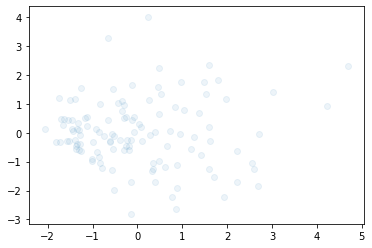

In [30]:
# view what 2-D projection of data looks like
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%time pca_x = PCA(n_components=2).fit_transform(a0)
plt.scatter(pca_x[:, 0], pca_x[:, 1],alpha=0.08)  # not too many natural groupings arising, eh?

In [31]:
from sklearn.manifold import TSNE
## let's try t-SNE method. manifold learning of high dimensional structures
%time X_tsne = TSNE(n_components=2).fit_transform(a0)  # 0.6s
df_tsne = pd.DataFrame(X_tsne, index=range(len(nokia)), columns=['x', 'y'])

Wall time: 588 ms


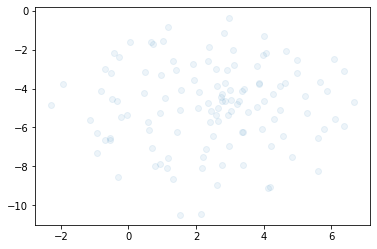

In [32]:
# create a scatterplot of the resulting 2-dimensional data
plt.scatter(df_tsne['x'], df_tsne['y'],alpha=0.08)

Execution Time:  0.026929378509521484


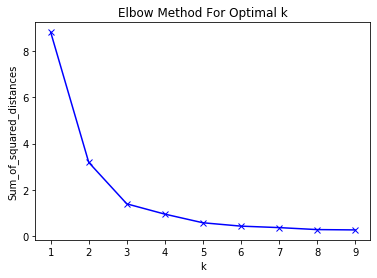

In [33]:
# finally, k-means-ish method for cluster-an.
# $conda install -c conda-forge scikit-learn-extra
from sklearn_extra.cluster import KMedoids
np.random.seed(42)
t1 = time.time()
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMedoids(n_clusters=k,metric="cosine").fit(X_tsne)
    Sum_of_squared_distances.append(km.inertia_)
print("Execution Time: ", time.time()-t1)  # 0.02s

# scree-plot of num_clusters with goodness_fit
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [34]:
km = KMedoids(n_clusters=3,metric="cosine").fit(X_tsne)
y_kmediod = km.predict(X_tsne)

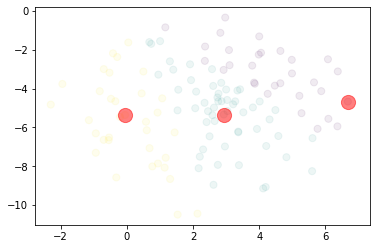

In [35]:
plt.scatter(df_tsne['x'], df_tsne['y'], c=y_kmediod, s=50, cmap='viridis',alpha=0.08)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

Will stop here for now. Ciao.

Sudhir